In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ROOT

from root_pandas import read_root, to_root

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier

from tqdm import tqdm
from itertools import islice

from collections import OrderedDict

from scipy.stats import linregress
from uncertainties import ufloat
from uncertainties.unumpy import nominal_values as noms
from uncertainties.unumpy import std_devs as stds

import sys
sys.path.insert(0, '../')
from scripts.metrics import tagging_power_score
from scripts.calibration import PolynomialLogisticRegression

In [25]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

# read and prepare dataset

In [3]:
data_dir = '/home/kheinicke/tank/flavourtagging/'
run_1_filenames = ['Bu2JpsiK_mu-k-e-TrainingTuple_2011_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2011_MU_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2012_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2012_MU_sweighted_kheinick.root',
                   ]
run_2_filenames = ['Bu2JpsiK_mu-k-e-TrainingTuple_2015_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2015_MU_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2016_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2016_MU_sweighted_kheinick.root',
                   ]
chunksize = 5000
maxslices = None

In [4]:
datasets = OrderedDict([
    ('RUNI', {
        'filenames': [data_dir + f for f in run_1_filenames],
    }),
    ('RUNII', {
        'filenames': [data_dir + f for f in run_2_filenames],
    }),
])

In [5]:
# just define some keyword arguments for read_root in a separate dict
data_kwargs = dict(
    key='DecayTree',  # the tree name
    columns=['B_OS_Kaon*',  # all branches that should be read
             'B_ID',
             'B_PT',
             'runNumber',
             'eventNumber',
             'SigYield_sw',
            ],
    chunksize=chunksize,  # this will create a generator, yielding subsets with 'chunksize' of the data
    where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',  # a ROOT where selection, does not work with array-variables
    flatten=True  # will flatten the data in the dimension of the first given column
)

In [6]:
def get_event_number(df, weight_column='SigYield_sw'):
    """ Use weighted sums
    """
    return np.sum(df.groupby('event_id')[weight_column].first())  # max, min, mean, first should give the same values here

In [7]:
# Read datasets and fill several event information
for key, d in datasets.items():
    filenames = d['filenames']
    entries = 0
    for f in filenames:
        rootfile = ROOT.TFile(f)
        tree = rootfile.Get('DecayTree')
        entries += tree.GetEntries()
    datasets[key]['entries'] = entries
    if maxslices is not None and maxslices < entries/chunksize:
        total = maxslices
    else:
        total = entries/chunksize
    df = pd.concat([df for df
                    in tqdm(islice(read_root(filenames, **data_kwargs), maxslices),
                            total=total)])
    datasets[key]['data'] = df

245it [05:33,  1.13s/it]                              
61it [01:11,  1.13it/s]                             


In [8]:
for key, d in datasets.items():
    df = d['data']
    df.rename(columns=dict(zip(df.columns, [c.replace('B_OS_Kaon', 'tp') for c in df.columns])), inplace=True)
    df['target'] = np.sign(df.B_ID) != np.sign(df.tp_ID)
    df['event_id'] = df.runNumber.apply(str) + '_' + df.eventNumber.apply(str)
    df['tp_PROBNNk_p'] = df['tp_PROBNNk-PROBNNp']
    df['tp_PROBNNk_pi'] = df['tp_PROBNNk-PROBNNpi']
    df['tp_PIDK_p'] = df['tp_PIDK-PIDp']
    datasets[key]['data'] = df
    datasets[key]['event_number'] = ufloat(get_event_number(df), np.sqrt(get_event_number(df)))

In [9]:
for key, d in datasets.items():
    df = d['data']
    datasets[key]['data']['tp_RecVertexIP'] = np.abs(df.tp_RecVertexIP)
    datasets[key]['data']['tp_ABSID'] = np.abs(df.tp_ID)

# apply kaon-specific selections

In [10]:
# this is the list of BDT variables formerly used
classic_MVA_features = ['tp_' + f for f in [
    "mult",
    "partP",
    "partPt",
    "nnkrec",
    "ptB",
    "IPs",
    "partlcs",
    "PIDNNk",
    "PIDNNpi",
    "PIDNNp",
    "ghostProb",
    "IPPU",
]]

In [11]:
# define all the classic selections for muon tagger here for a query
queries = ['tp_' + f for f in [
    'partP > 2.0',
    'partPt > 0.7',
    'TRTYPE == 3',
    'partlcs < 3',
    'minPhiDistance > 0.005',
    'MuonPIDIsMuon == 0',
#     'TRLH > -999',
    'ghostProb < 0.35',
    'PROBNNmu < 0.8',
    'PROBNNe < 0.8',
    'PIDNNpi < 0.8',
    'PIDNNk > 0.25',
    'PIDNNp < 0.8',
    'PROBNNk_p > 0.0',
    'PROBNNk_pi > -0.6',
#     'PIDK > -100',
    'PIDK != 0',
    'PIDK != -1000',
#     'PIDK_p > -300',
    'IPPU > 6.0',
    'IPs > 4.0',
    'RecVertexIP < 1.6',
    'RecVertexIPErr != 0',
    'IsSignalDaughter == 0',
    'ABSID != 13',
]]

selection_features = [q.split(' ')[0] for q in queries]

In [12]:
# apply query
for key, d in datasets.items():
    df = d['data']
    selected_df = df.query(' and '.join(queries))
    selected_df.reset_index(drop=True, inplace=True)
#     _, bins, _ = plt.hist(df.groupby('event_id')['target'].mean(), alpha=0.5, bins=30)
#     plt.hist(selected_df.groupby('event_id')['target'].mean(), alpha=0.5, bins=bins)
#     plt.show()
#     _, bins, _ = plt.hist(df.groupby('event_id')['target'].count(), alpha=0.5, bins=30)
#     plt.hist(selected_df.groupby('event_id')['target'].count(), alpha=0.5, bins=bins)
#     plt.show()
    max_pt_df = selected_df.iloc[selected_df.groupby('event_id')['tp_partPt'].idxmax()]
    sel_event_number = ufloat(get_event_number(max_pt_df), np.sqrt(get_event_number(max_pt_df)))
    datasets[key]['selected_data'] = selected_df
    datasets[key]['event_number_selected'] = sel_event_number
    datasets[key]['max_pt_data'] = max_pt_df
    event_number = datasets[key]['event_number']
    sel_efficiency = sel_event_number / event_number
    avg_omega = ufloat(np.sum(max_pt_df.SigYield_sw * ~max_pt_df.target) / np.sum(max_pt_df.SigYield_sw),
                       np.sqrt(np.sum(max_pt_df.SigYield_sw * ~max_pt_df.target)) / np.sum(max_pt_df.SigYield_sw))
    avg_tagging_power = sel_efficiency * (1 - 2 * avg_omega)**2
    print('{}:\tε:\t{}% (before {:.0f}, after {:.0f})'.format(key, sel_efficiency * 100, event_number.n, sel_event_number.n))
    print('\t⍵:\t{}%'.format(avg_omega * 100))
    print('\tD2:\t{}%'.format((1 - 2 * avg_omega)**2 * 100))
    print('\tε_eff:\t{}%'.format(avg_tagging_power * 100))

RUNI:	ε:	14.04+/-0.04% (before 1084717, after 152287)
	⍵:	39.56+/-0.16%
	D2:	4.36+/-0.13%
	ε_eff:	0.612+/-0.019%
RUNII:	ε:	12.45+/-0.07% (before 281845, after 35101)
	⍵:	40.25+/-0.34%
	D2:	3.81+/-0.26%
	ε_eff:	0.474+/-0.033%


# train the classifier

In [13]:
for key, d in datasets.items():
    df = d['max_pt_data']
    train_data, _data = train_test_split(df, train_size=0.333, random_state=1)
    test_data, calib_data = train_test_split(_data, train_size=0.5, random_state=1)
    model = XGBClassifier(max_depth=3, n_estimators=300, nthread=24)
#     model = GradientBoostingClassifier()
#     model = RandomForestClassifier(n_estimators=100, n_jobs=24)
    model.fit(train_data[classic_MVA_features], train_data.target)
    model_weighted = XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=500, nthread=12)
    model_weighted.fit(train_data[classic_MVA_features][train_data.SigYield_sw > -10],
                       train_data.target[train_data.SigYield_sw > -10],
                       sample_weight=train_data.SigYield_sw[train_data.SigYield_sw > -10])
    datasets[key]['model'] = model
    datasets[key]['model_weighted'] = model_weighted
    for subset_name in ['train_data', 'test_data', 'calib_data']:
        datasets[key][subset_name] =  locals()[subset_name].copy(deep=True)

RUNI	train_data	auc	62.57%	58.91%
	test_data	auc	55.76%	56.52%
	calib_data	auc	55.98%	56.55%
RUNII	train_data	auc	74.17%	64.11%
	test_data	auc	55.08%	56.26%
	calib_data	auc	55.13%	56.10%


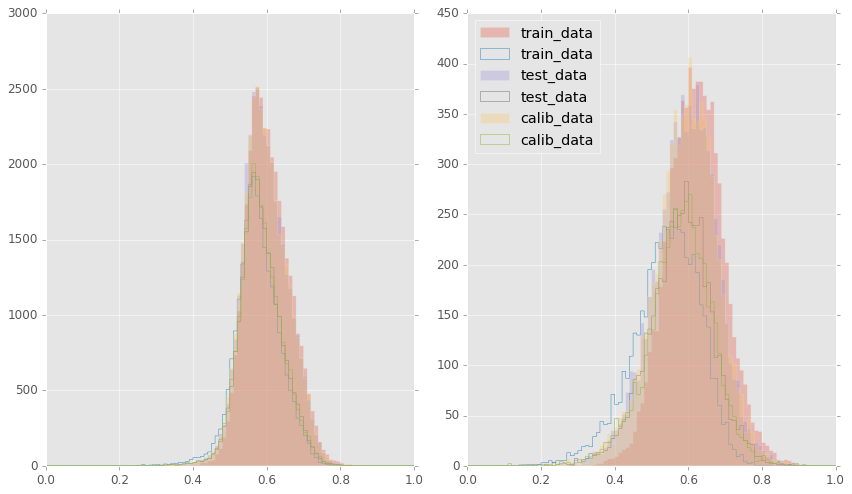

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2)
for (key, d), ax in zip(datasets.items(), (ax1, ax2)):
    plt.axes(ax)
    print(key, end='')
    plt.subplots
    for subset_name in ['train_data', 'test_data', 'calib_data']:
        subset = datasets[key][subset_name]
        subset['probas'] = d['model'].predict_proba(subset[classic_MVA_features])[:,1]
        subset['probas_weighted'] = d['model_weighted'].predict_proba(subset[classic_MVA_features])[:,1]
        subset['prediction'] = subset.probas > 0.5
        subset['prediction_weighted'] = subset.probas_weighted > 0.5
        datasets[key][subset_name] = subset
        auc_score = roc_auc_score(subset.target, subset.probas)
        auc_score_weighted = roc_auc_score(subset.target, subset.probas_weighted, sample_weight=subset.SigYield_sw)
        print('\t{}\tauc\t{:2.2f}%\t{:2.2f}%'.format(subset_name, auc_score * 100, auc_score_weighted * 100))
        plt.hist(subset.probas[subset.target], bins=100, range=(0, 1),
                 alpha=0.3, label=subset_name, histtype='stepfilled')
        plt.hist(subset.probas[~subset.target], bins=100, range=(0, 1),
                 alpha=1.0, label=subset_name, histtype='step')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

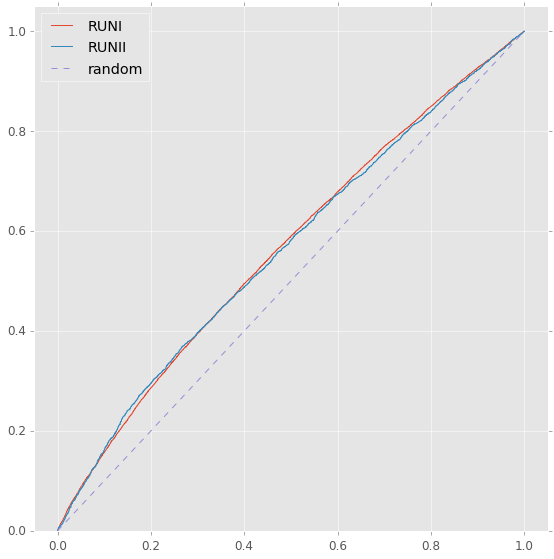

In [15]:
plt.figure(figsize=(8, 8))
for (key, d), style in zip(datasets.items(), ['--', '-.']):
    for subset_name in ['test_data']:
        probas = d[subset_name].probas_weighted
        fpr, tpr, _ = roc_curve(d[subset_name].target, probas, sample_weight=d[subset_name].SigYield_sw)
        plt.plot(fpr, tpr, label=key)
plt.plot([0, 1], '--', label='random')
plt.tight_layout()
plt.xlim(-0.05, 1.05)
plt.ylim(0, 1.05)
plt.legend(loc='best')
plt.savefig('./build/muon-xgb-roc.pdf')
plt.show()

In [16]:
def proba_bins(x, y_true, errs=True, bins=10, range=None, sample_weight=None, auto_fill=False):
    """ Bin data by x and calculate the amount of y_true in each bin,
        errors will be (bin_width/2, sqrt(bin_count))
    """
    if sample_weight is None:
        sample_weight = np.ones(x.shape)

    if auto_fill:
        pass
#         if not isinstance(bins, int):
#             raise ValueError('If auto_fill is True, bins needs to be an integer')
#         bin_content = len(x) / bins
#         bin_edges = [np.min(x)]
#         bins = np.array(bin_edges)
    hist, bin_edges = np.histogram(x, bins=bins, range=range)
    xs = np.array([(x_low + x_high)/2 for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
    true_sums = np.array([np.sum(sample_weight[(x > x_low) & (x <= x_high)])
                          for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
    ys = (np.array([np.sum(sample_weight[(x > x_low) & (x <= x_high) & (np.array(y_true) == True)])
                    for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
          / true_sums)
    if errs:
        y_errs = (np.array([np.sqrt(np.sum(sample_weight[(x > x_low) & (x <= x_high) & (np.array(y_true) == False)]))
                            for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
                  / true_sums)
        x_errs = [(x_high - x_low) / 2 for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])]
        return xs, ys, y_errs, x_errs
    else:
        return xs, ys

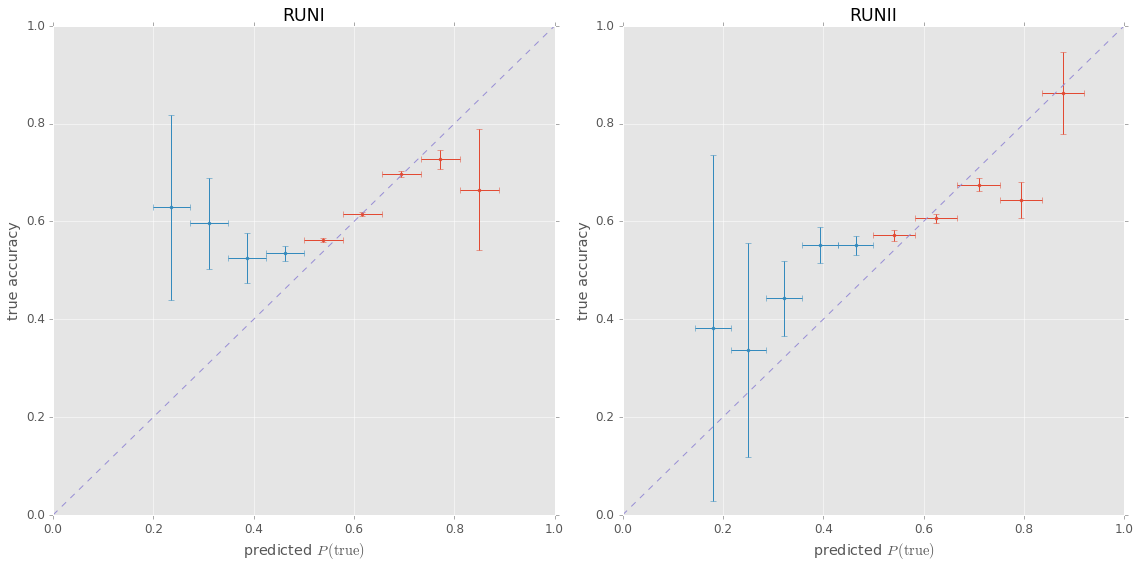

In [17]:
_, axes = plt.subplots(1, 2, figsize=(16, 8))
bins = np.unique(np.concatenate([np.arange(0, 0.3, 0.15),
                                 np.arange(0.3, 0.4, 0.1),
                                 np.arange(0.4, 0.9, 0.05),
                                 [1]]))
for (key, d), ax in zip(datasets.items(), axes):
    plt.axes(ax)
    test_data = d['test_data']
    x = test_data.probas
    y = test_data.target
    plt.errorbar(*proba_bins(x[test_data.prediction], y[test_data.prediction],
                             sample_weight=test_data.SigYield_sw[test_data.prediction],
                             auto_fill=True, bins=5), fmt='.')
    plt.errorbar(*proba_bins(x[~test_data.prediction], y[~test_data.prediction],
                             sample_weight=test_data.SigYield_sw[~test_data.prediction],
                             auto_fill=True, bins=5), fmt='.')
    plt.plot([0, 1], '--')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel(r'predicted $P\,(\mathrm{true})$')
    plt.ylabel('true accuracy')
    plt.title(key)
plt.savefig('./build/classic-raw-bdt.pdf')
plt.tight_layout()
plt.show()

In [18]:
for key, d in datasets.items():
    calib_data = d['calib_data']
    test_data = d['test_data']
    
    # polynomial logistic regression
    calibration_model = PolynomialLogisticRegression(power=4, solver='lbfgs', n_jobs=12)
    calibration_model.fit(calib_data.probas.reshape(-1, 1), calib_data.target)
    datasets[key]['logistic_calib_model'] = calibration_model
    
    # isotonic regression
    isotonic_calib_model = IsotonicRegression(y_min=0, y_max=1)
    isotonic_calib_model.fit(calib_data.probas, calib_data.target)
    datasets[key]['isotonic_calib_model'] = isotonic_calib_model
    def model(x):
        return 1 / (1 + np.exp(-x))
    for subset_name in ['train_data', 'test_data', 'calib_data']:
        datasets[key][subset_name]['calib_probas'] = calibration_model.predict_proba(d[subset_name].probas)[:,1]
        datasets[key][subset_name]['isotonic_probas'] = isotonic_calib_model.predict(d[subset_name].probas)

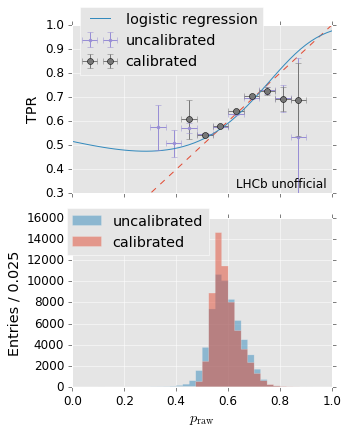

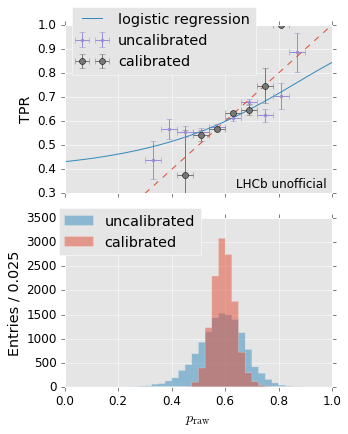

In [27]:
for key, d in datasets.items():
    test_data = d['test_data']
    fig = plt.figure(figsize=(5, 6))
    ax_top = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    ax_bottom = plt.subplot2grid((4, 1), (2, 0), sharex=ax_top, rowspan=2)
    plt.axes(ax_top)
    plt.plot([0, 1], '--')
    xs = np.linspace(0, 1)
    calibration_model = d['logistic_calib_model']
    plt.plot(xs, calibration_model.predict_proba(xs)[:,1],
             label='logistic regression')
    calib_probas = datasets[key]['test_data'].calib_probas
    plt.errorbar(*proba_bins(test_data.probas, test_data.target, sample_weight=test_data.SigYield_sw, range=(0.3, 0.9)),
                 fmt='.', label='uncalibrated')
    plt.errorbar(*proba_bins(calib_probas, test_data.target, sample_weight=test_data.SigYield_sw, range=(0.3, 0.9)),
                 fmt='o', label='calibrated')
    plt.setp(ax_top.get_xticklabels(), visible=False)
    plt.ylabel('TPR')
    plt.xlim(0, 1)
    plt.ylim(0.3, 1)
    plt.legend(bbox_to_anchor=(0, 1.15), loc='upper left')
    plt.text(0.98, 0.02, 'LHCb unofficial', ha='right', va='bottom', transform=plt.gca().transAxes)
    
    plt.axes(ax_bottom)
    _, bins, _ = plt.hist([calib_probas,
              test_data.probas,
             ], bins=40, range=(0, 1), histtype='stepfilled', alpha=0.5,
             label=['calibrated',
                    'uncalibrated',])
    plt.legend(bbox_to_anchor=(-0.05, 1.1), loc='upper left')

    binwidth = (bins[1] - bins[0])
    plt.ylabel('Entries / {}'.format(binwidth))
    plt.xlabel(r'$p_\mathrm{raw}$')
    plt.tight_layout()
    plt.savefig('./build/kaon-calibration-dist-{}.pdf'.format(key), bbox_inches='tight')
    plt.show()

In [20]:
def weighted_mean(values, weights=None):
    if weights is None:
        weights = np.ones(len(values))
    V1 = np.sum(weights)
    V2 = np.sum(weights**2)
    mean = np.sum(weights * values) / np.sum(weights)
    variance = np.sum(weights * (values - mean)**2) / V1  # (V1 - V2 / V1)
    return ufloat(mean, np.sqrt(variance))

def mean(values):
    return ufloat(np.mean(values), np.std(values))

In [21]:
for key, d in datasets.items():
    test_data = d['test_data']
    eff = datasets[key]['event_number_selected'] / datasets[key]['event_number']
    p = test_data.calib_probas
    w = test_data.SigYield_sw
    d2s = (w * (1 - 2 * p)**2).sum()
    N = datasets[key]['event_number'] / 3
    Ntagged = datasets[key]['event_number_selected'] / 3
    print(key)
    print(eff * 100)
    print(d2s / Ntagged * 100)
    print(d2s / N * 100)
    print(d2s / N / np.sqrt(N.n) * 100)

RUNI
14.04+/-0.04
4.590+/-0.012
0.6444+/-0.0006
0.0010717+/-0.0000010
RUNII
12.45+/-0.07
4.429+/-0.024
0.5515+/-0.0010
0.0017994+/-0.0000034


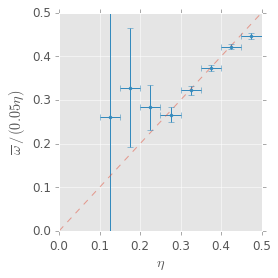

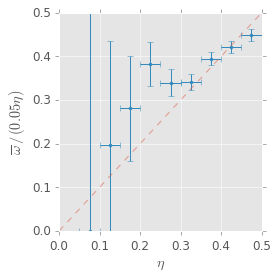

In [22]:
# only plot raw distribution
for key, d in datasets.items():
    plt.figure(figsize=(4, 4))
    data = d['test_data']
    data['etas'] = np.where(data.probas > 0.5, 1 - data.probas, data.probas)
    plt.plot([0, 0.5], [0, 0.5], '--', alpha=0.5)
    plt.errorbar(*proba_bins(data.etas, ~data.target, sample_weight=data.SigYield_sw, range=(0, 0.5)),
                 fmt='.', label='uncalibrated')
    plt.ylim(0, 0.5)
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\overline{\omega} \,/\, (0.\!05 \eta)$')
    plt.tight_layout()
    plt.savefig('./build/mistag-dist-{}.pdf'.format(key), bbox_inches='tight')
    plt.show()

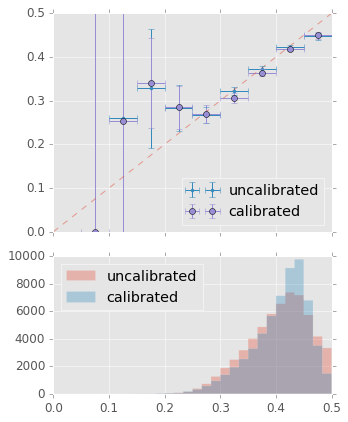

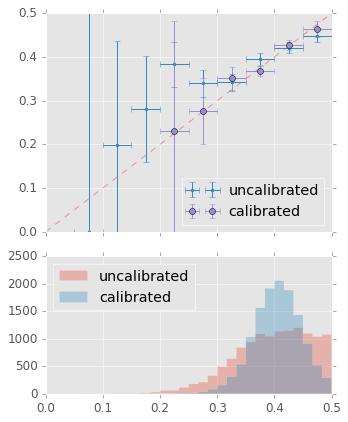

In [23]:
for key, d in datasets.items():
    plt.figure(figsize=(5, 6))
    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=3)
    ax2 = plt.subplot2grid((5, 1), (3, 0), rowspan=2, sharex=ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    data = d['test_data']
    data['etas'] = np.where(data.probas > 0.5, 1 - data.probas, data.probas)
    data['calib_etas'] = np.where(data.calib_probas > 0.5, 1 - data.calib_probas, data.calib_probas)
    plt.axes(ax1)
    plt.plot([0, 0.5], [0, 0.5], '--', alpha=0.5)
    plt.errorbar(*proba_bins(data.etas, ~data.target, sample_weight=data.SigYield_sw, range=(0, 0.5)),
                 fmt='.', label='uncalibrated')
    plt.errorbar(*proba_bins(data.calib_etas, ~data.target, sample_weight=data.SigYield_sw, range=(0, 0.5)),
                 fmt='o', label='calibrated')
    plt.ylim(0, 0.5)
    plt.legend(loc='best')
    plt.axes(ax2)
    plt.hist(data.etas, bins=30, range=(0, 0.5), alpha=0.33, label='uncalibrated', histtype='stepfilled')
    plt.hist(data.calib_etas, bins=30, range=(0, 0.5), alpha=0.33, label='calibrated', histtype='stepfilled')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [24]:
to_root(datasets['RUNI']['max_pt_data'], '../data/kaon-classic-run1.root')
to_root(datasets['RUNII']['max_pt_data'], '../data/kaon-classic-run2.root')

/home/kheinicke/.local/lib/python3.4/site-packages/root_numpy/_tree.py:570: UserWarning: converter for dtype('O') is not implemented (skipping)
  _librootnumpy.array2root(arr, filename, treename, mode)
